# Notebook for visualizing the results of a stylegan3 training


In [21]:
import os

dataset_name = f"ulla"
seed = 42

dataset_file = dataset_name + "_train" + (f"_{seed}" if seed is not None else "")

results_dir = f"training-runs/{dataset_file.upper()}"
experiment_name = f"00002-stylegan3-t-{dataset_file}-gpus2-batch128-gamma0.125"

file_name = "stats.jsonl"
training_options_file_name = "training_options.json"
dataset_summary_file_name = f"data/{dataset_name}/patches/processing_summary.json"

file_path = os.path.join(results_dir, experiment_name, file_name)
if not os.path.isfile(file_path):
    print(f"Error: The file {file_path} does not exist.")

import json

with open(dataset_summary_file_name, "r") as f:
    summary = json.load(f)

label_map = summary.get("label_map", {})
print("Label Map:", label_map)

# Labels for the classes
class_labels = [int(label) for label in label_map.keys()]
print("Class Labels:", class_labels)


Label Map: {'1': 2, '3': 4, '6': 7, '7': 8, '8': 9}
Class Labels: [1, 3, 6, 7, 8]


In [22]:
from visualization_utils import read_jsonl, extract_metrics, extract_classification_metrics, format_time, summarize_training_stats, \
    summarize_training_options, extract_confusion_matrix, plot_confusion_matrix, plot_metric, print_accuracies_per_class, \
    compute_avg_accuracy, compute_overall_accuracy, plot_accuracies, extract_best_tick, class_colors

In [23]:
summarize_training_options(os.path.join(results_dir, experiment_name, training_options_file_name))

📋 Training Configuration Summary
────────────────────────────────────
⚖️  Class weight: 0.1
🖥️  Number of GPUs: 2
📦 Batch size: 128
🎯 Uniform class labels: False
🧪 Discriminator on generated images: True
🎛️  ADA target present ✅ → Value: 0.6


In [24]:
jsonl_data = read_jsonl(file_path)
metrics = extract_metrics(jsonl_data, class_labels=class_labels)
summarize_training_stats(metrics, exclude_first_tick=True)

🕒 Total time: 26min 53s
📊 Total kimg: 173.056
📈 Total ticks: 18
⏱️ Mean time per tick: 1min 21s (std: 17s)
⏳ Mean time per kimg: 8s (std: 0s)


In [25]:
print("────────────────────────────────────")
print("Using average accuracy as performance key")
print("────────────────────────────────────")
best_tick_performance = extract_best_tick(
    jsonl_data, class_labels, performance_key="avg", verbose=True, only_tick_with_pkl=False, network_snapshot_ticks=None
)

────────────────────────────────────
Using average accuracy as performance key
────────────────────────────────────
📊 Best Tick Performance Summary
────────────────────────────────────
⏱️  Tick: 17
🖼️  kimg: 172.032
📈 Avg Accuracy (Train): 0.9792 ± 0.0363
📊 Avg Accuracy (Val):   1.0000 ± 0.0000
🏁 Overall Accuracy (Train): 0.9915
✅ Overall Accuracy (Val):   1.0000


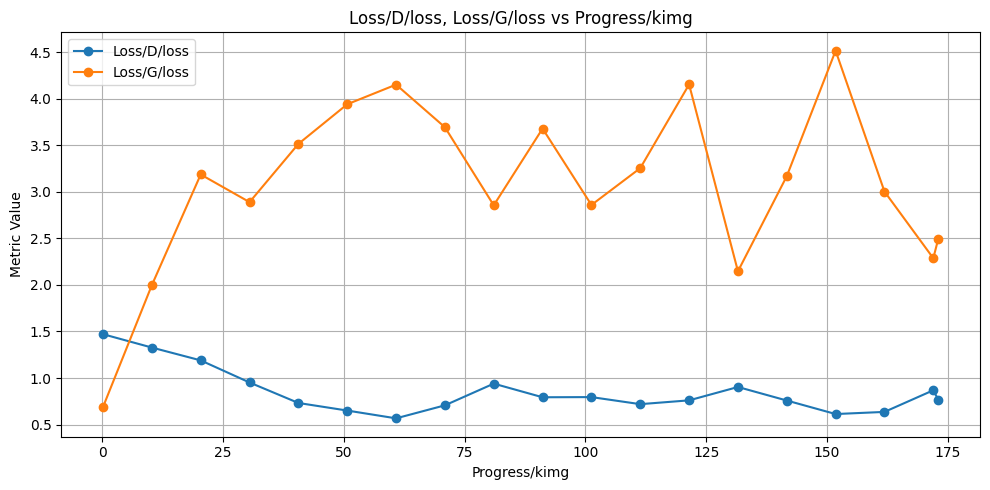

In [26]:
plot_metric(metrics, metrics=["Loss/D/loss", "Loss/G/loss"], x_axis="Progress/kimg")

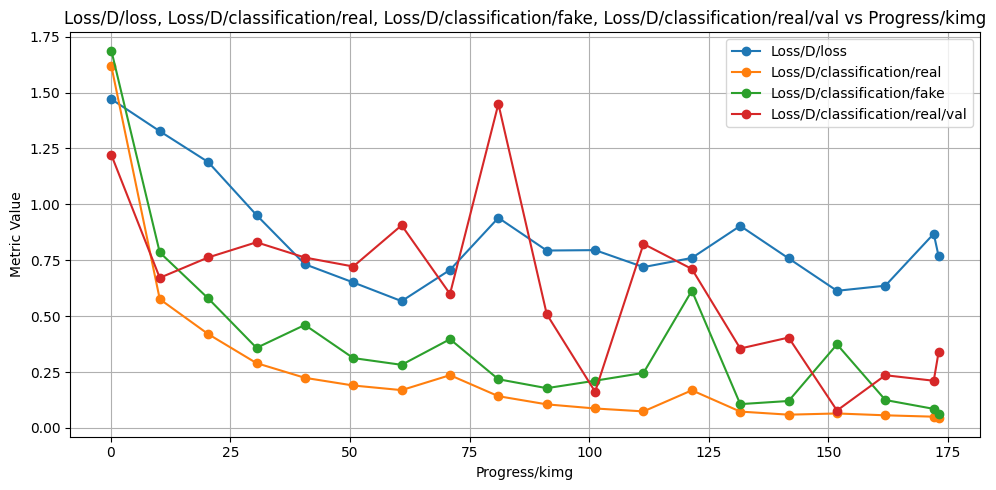

In [27]:
plot_metric(
    data=metrics,
    metrics=[
        "Loss/D/loss",
        "Loss/D/classification/real",
        "Loss/D/classification/fake",
        "Loss/D/classification/real/val",
    ],
    x_axis="Progress/kimg",
)

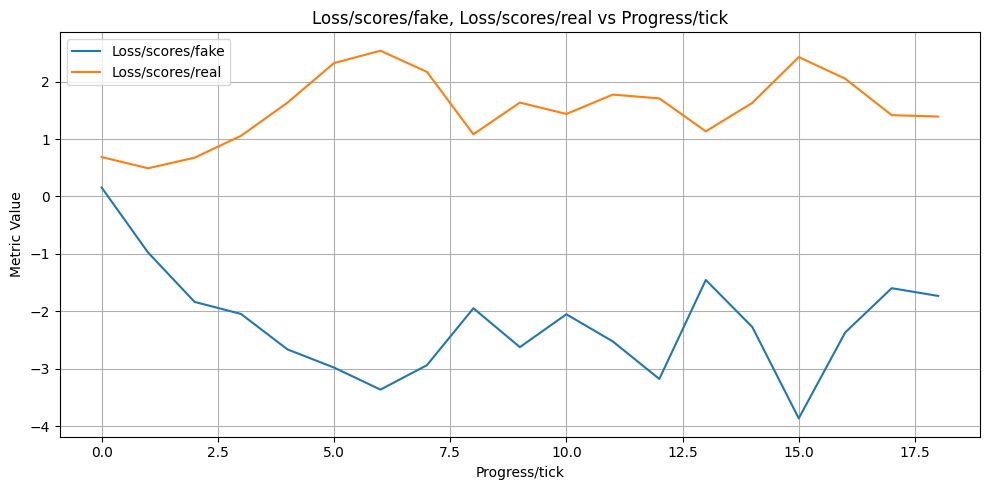

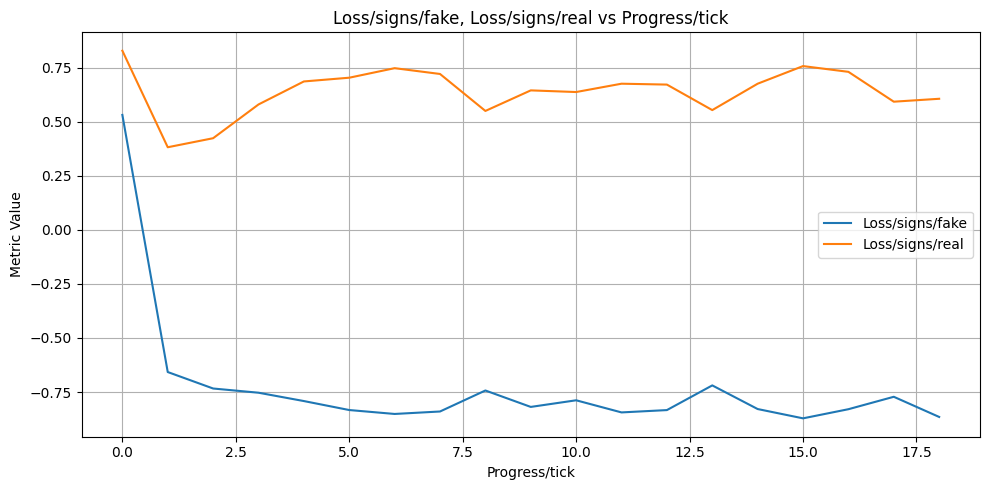

In [28]:
plot_metric(metrics, metrics=["Loss/scores/fake", "Loss/scores/real"], x_axis="Progress/tick", marker=None)
plot_metric(metrics, metrics=["Loss/signs/fake", "Loss/signs/real"], x_axis="Progress/tick", marker=None)

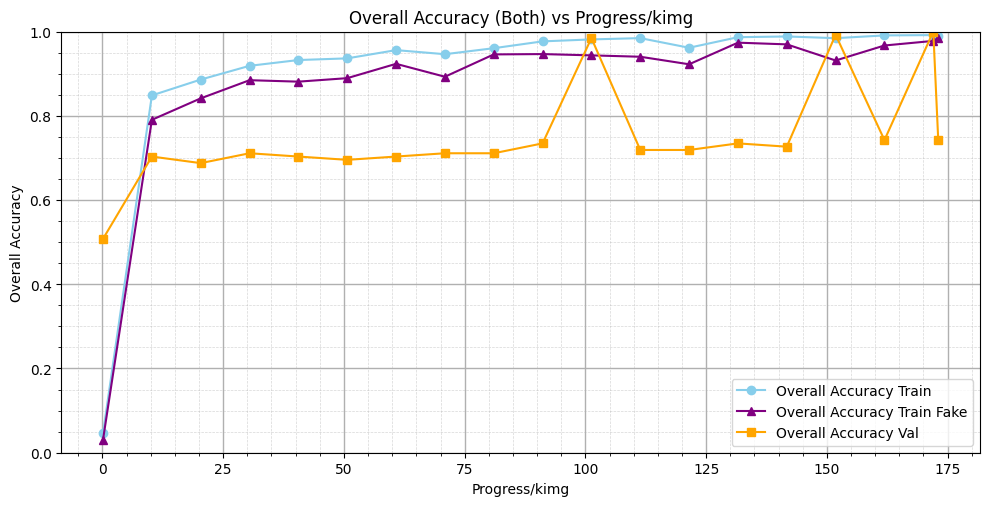

In [29]:
classification_metrics = extract_classification_metrics(jsonl_data, class_labels=class_labels)
metrics["overall_accuracy_train"], metrics["overall_accuracy_val"], metrics["overall_accuracy_train_fake"] = (
    compute_overall_accuracy(classification_metrics)
)
plot_accuracies(
    metrics,
    class_labels=class_labels,
    plot_std_in_avg_accuracy=False,
    plot_type="overall",
    dataset="both",
    include_fake=True,
)

Last 10 accuracies per class (val):
Class 1: ['0.304', '1.000', '0.304', '0.304', '0.304', '0.304', '1.000', '0.304', '1.000', '0.304']
Class 3: ['1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000']
Class 6: ['1.000', '1.000', '1.000', '0.938', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000']
Class 7: ['1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000']
Class 8: ['0.667', '0.667', '0.333', '0.500', '0.667', '0.500', '0.833', '0.833', '1.000', '0.833']
Average accuracies over the last 10 ticks: ['0.794', '0.933', '0.728', '0.748', '0.794', '0.761', '0.967', '0.828', '1.000', '0.828']


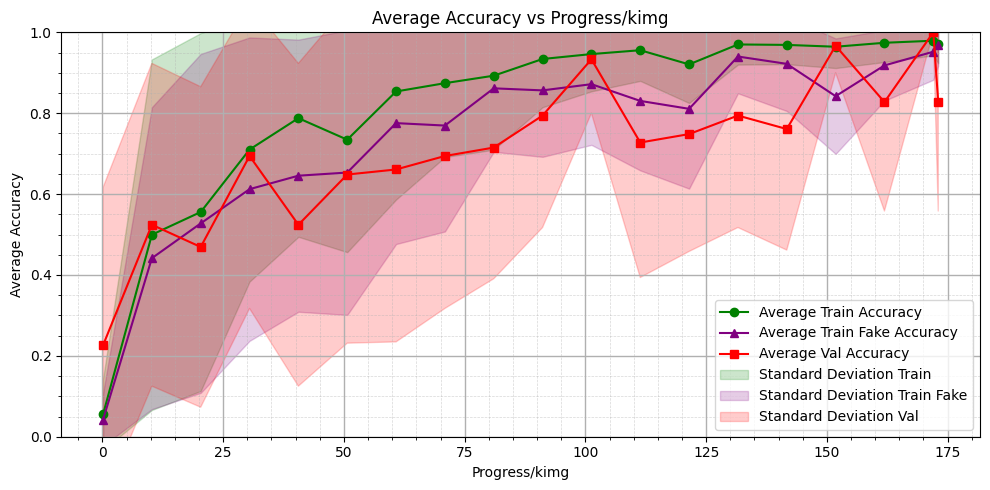

In [30]:
print_accuracies_per_class(metrics, class_labels, last_ticks=10, data_type="val")
plot_accuracies(
    metrics,
    class_labels=class_labels,
    plot_std_in_avg_accuracy=True,
    plot_type="average",
    dataset="both",
    include_fake=True,
)

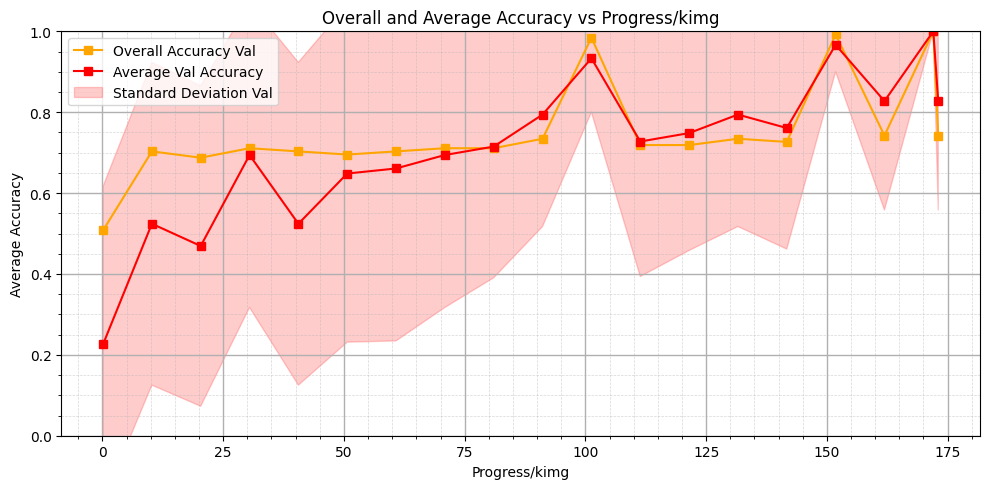

In [31]:
plot_accuracies(
    metrics,
    class_labels=class_labels,
    plot_std_in_avg_accuracy=True,
    plot_type="both",
    dataset="val",
)

In [32]:
class_names_map = ["Auga", "Terra", "Pedras", "Asfalto", "Formigón", "Tellados", "Prados", "Árbores Nativas", "Piñeiros", "Eucaliptos"]

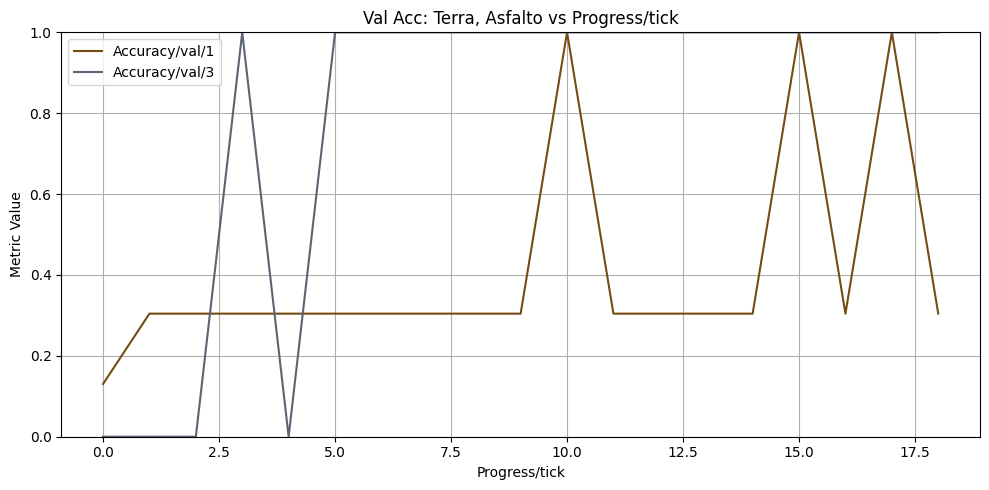

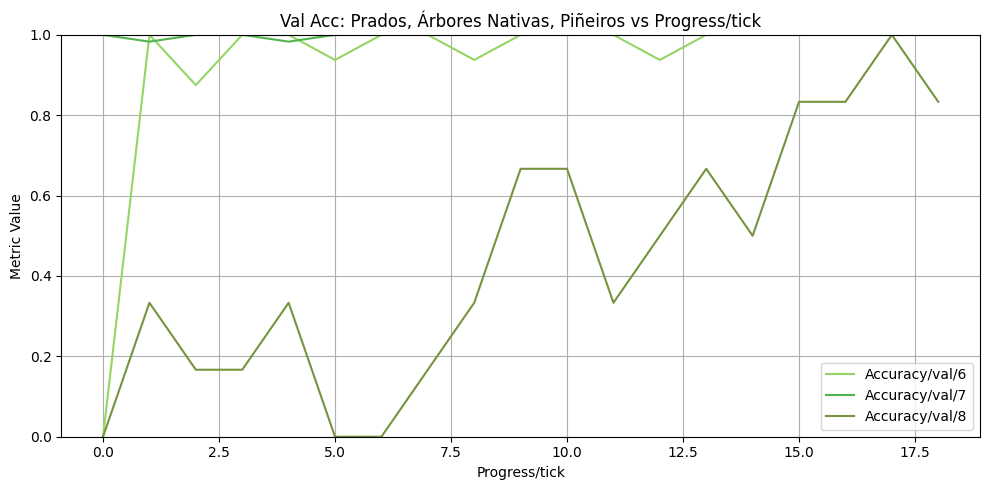

In [33]:
minority_class_labels = [1, 2, 3, 4, 5]
colors = [class_colors[c] for c in minority_class_labels]
plot_metric(
    metrics,
    metrics=[f"Accuracy/val/{c}" for c in minority_class_labels],
    x_axis="Progress/tick",
    marker=None,
    ylim=(0, 1),
    colors=colors,
    title="Val Acc: " + ", ".join(class_name for i, class_name in enumerate(class_names_map) if i in minority_class_labels and i in class_labels) + " vs Progress/tick"
)
mayority_class_labels = [0, 6, 7, 8, 9]
colors = [class_colors[c] for c in mayority_class_labels]
plot_metric(
    metrics,
    metrics=[f"Accuracy/val/{c}" for c in mayority_class_labels],
    x_axis="Progress/tick",
    marker=None,
    ylim=(0, 1),
    colors=colors,
    title="Val Acc: " + ", ".join(class_name for i, class_name in enumerate(class_names_map) if i in mayority_class_labels and i in class_labels) + " vs Progress/tick"
)

Tick: 18/18
kimg used for training: 173.056/173.056


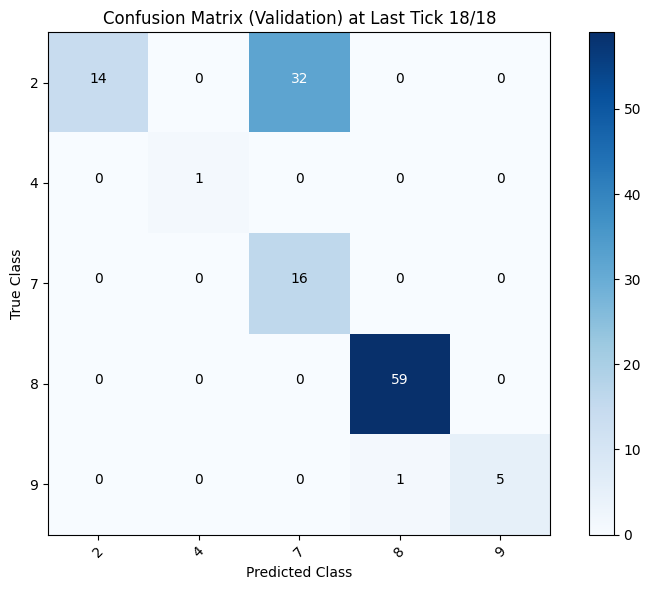

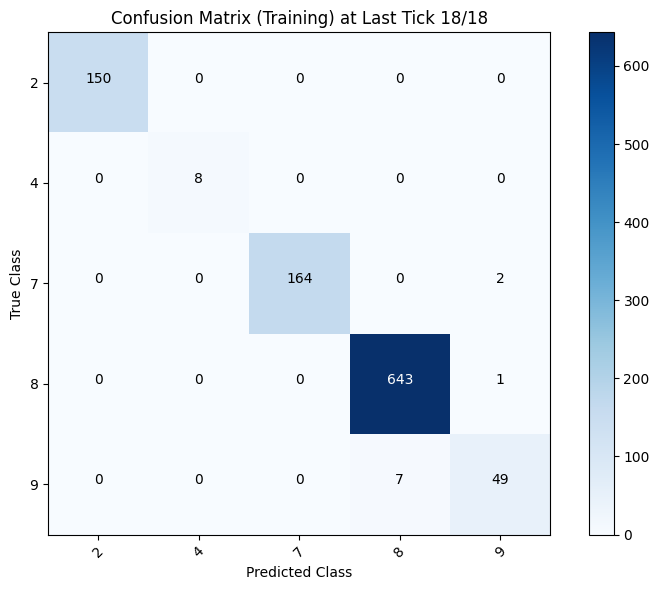

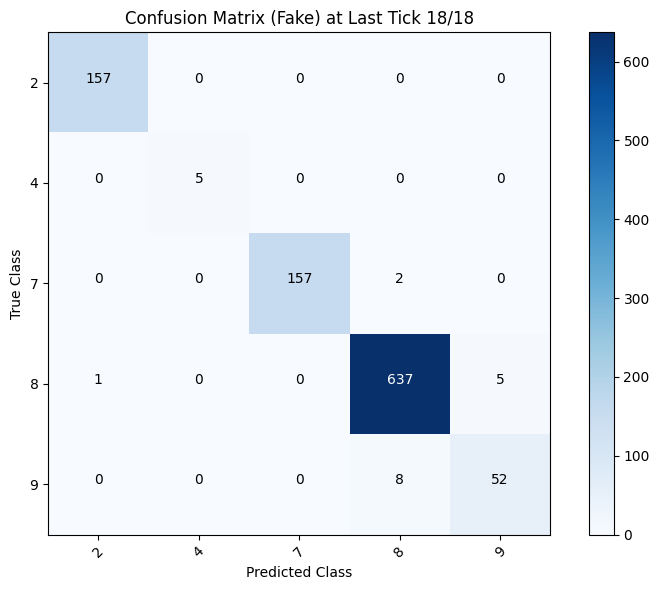

In [36]:
total_tick = int(metrics["Progress/tick"][-1])
total_kimg = float(metrics["Progress/kimg"][-1])

print(f"Tick: {total_tick}/{total_tick}")
print(f"kimg used for training: {total_kimg:.3f}/{total_kimg:.3f}")

# ------------- Validation ------------- #
confusion_matrix = extract_confusion_matrix(
    jsonl_data, class_labels=class_labels, data_type="val"
)
plot_confusion_matrix(
    confusion_matrix, class_labels=class_labels, title=f"Confusion Matrix (Validation) at Last Tick {total_tick}/{total_tick}"
)

# ------------- Training (real) ------------- #
confusion_matrix = extract_confusion_matrix(
    jsonl_data, class_labels=class_labels, data_type="real"
)
plot_confusion_matrix(
    confusion_matrix, class_labels=class_labels, title=f"Confusion Matrix (Training) at Last Tick {total_tick}/{total_tick}"
)

# ------------- Training (fake) ------------- #
confusion_matrix = extract_confusion_matrix(
    jsonl_data, class_labels=class_labels, data_type="fake"
)
plot_confusion_matrix(confusion_matrix, class_labels=class_labels, title=f"Confusion Matrix (Fake) at Last Tick {total_tick}/{total_tick}")